# Temperature Profiling of 2D heat distribution

### In 2D, the temperature distribution across an area is governed by
$$
\frac{\partial T(x, y, t)}{\partial t} = \alpha \left( \frac{\partial^2 T(x, y, t)}{\partial x^2} + \frac{\partial^2 T(x, y, t)}{\partial y^2} \right)
$$
### Assuming $T(t,0,0) = T(t,L,L) = 0$ on a square $[0,L]\times[0,L] $ domain, the solutions are:
$$
T(x, y, t) = \sum_{n=1}^\infty \sum_{m=1}^\infty c_n c_m \sin\left(\frac{n\pi x}{L}\right) \sin\left(\frac{m\pi y}{L}\right) \exp\left(-\alpha t \left(\frac{n^2 \pi^2}{L^2} + \frac{m^2 \pi^2}{L^2}\right)\right)
$$
### For simplicity, let's define: $k_{nm} = \frac{n^2 \pi^2}{L^2} + \frac{m^2 \pi^2}{L^2}$
$$
T(x, y, t) = \sum_{n=1}^\infty \sum_{m=1}^\infty c_n c_m \sin\left(\frac{n\pi x}{L}\right) \sin\left(\frac{m\pi y}{L}\right) \exp\left(-\alpha  t  k_{nm}\right)
$$

### The covariance matrix over the coeffecicents $c_{nm}$ should now be $n \times m$ because there are m combinations for each n. let $s = n \times m$, the matrix is given by:
$$
A_{s,s'} = e^{\alpha \left( k_s \right) t} \delta_{s,s'}
$$

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(42)

def prior_covar(time: float,
                N_modes: int, 
                alpha: float,
                Length_x: float) -> np.ndarray:
    """
    Calculates the diagonal prior covariance matrix A explicitly. Assume square domain
        A_{(nm)(nm)} = exp(+alpha * t * [(n*pi/Lx)^2 + (m*pi/Ly)^2])
    Returns a full diagonal matrix of size (Nn*Nm) x (Nn*Nm).
    Uses (n+1) and (m+1) convention for modes matching basis functions.
    """
    t = time
    a = alpha
    modes_n = np.arange(1, N_modes + 1)
    modes_m = np.arange(1, N_modes + 1)

    kx_sq = (modes_n * np.pi / Length_x)**2
    ky_sq = (modes_m * np.pi / Length_x)**2
    k_nm_sq = kx_sq[:, None] + ky_sq[None, :] # Shape (Nn, Nm)

    # Calculate diagonal elements of A (positive exponent)
    A_diag_2d = np.exp(a * t * k_nm_sq) # Note the positive sign here

    # Flatten and create the full diagonal matrix
    A_diag_flat = A_diag_2d.flatten()
    A = np.diag(A_diag_flat)

    return A

def inv_prior_covar(A: np.ndarray) -> np.ndarray:
    """
    Calculates the diagonal elements of the inverse of a diagonal matrix A.
    Efficiently computes 1 / A[i, i].
    """
    # Extract the diagonal elements of A
    diag_A = np.diag(A)
    A_inv_diag = np.divide(1.0, diag_A, out=np.zeros_like(diag_A), where=diag_A!=0)
    # Alternatively:
    # epsilon = 1e-100 # A very small number to prevent division by zero
    # A_inv_diag = 1.0 / (diag_A + epsilon)

    return A_inv_diag

# Example
t= 0
a = 0.01
modes = 2
L = 1
print(prior_covar(t,modes, a, L))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


### The Kernel function is a heuristic  function  which represents how function values at different points are correlated and fully encodes our prior information. For the 2D case, the kernel function captures the correlation between $x_1$ and $x_2$ and $x_1'$ and $x_2'$, so the intputs to the kernel function are $\mathit{X} = [x_1,x_2]$ and $\mathit{X'} = [x_1,x_2]$:
$$
K(\mathit{X},\mathit{X'}) = K((x_1,x_2), (x_1',x_2')) = \sum_{m=1}^N\sum_{n=1}^{N} A^{-1}_{s,s'} \sin(\frac{n\pi x_1}{L})\sin(\frac{m\pi x_2}{L})\sin(\frac{n\pi x_1'}{L})\sin(\frac{m\pi x_2'}{L})
$$

### Compute the covariance matrix of the training data. 
### Let $\mathit{X} = [x_1,x_2], \mathit{X'} = [x_1',x_2']$
$$
\begin{align}

\bar{K}_{i,j} &= K(\mathit{X} , \mathit{X'}) + \sigma^2\delta_{i,j}\\
              &= K((x_i, x_i), (x_j', x_j')) + \sigma^2\delta_{i,j}
\end{align}
$$

In [85]:
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(42)

def kernel_function(Lx: float,
                     N_modes: int,
                     x1: float, 
                     x2: float,
                     x1_p: float,
                     x2_p: float,
                     A_inv_diag: np.ndarray)-> float:
    ''' 
    Computes kernel function at time t: 
        K((x1,x1'),(x2,x2')) = \sum_n \sum_m A^{-1}_{(nm),(nm)'} B_n(x_1) B_m(x_2) B_m(x_1') B_m(x_2') 
        B_n(x1) = sin(n pi x1/L) 
    '''
    N = N_modes
    M = N_modes # Assuming N=M often
    modes_n = np.arange(1, N + 1)
    modes_m = np.arange(1, M + 1)
    kx = modes_n * np.pi / Lx
    ky = modes_m * np.pi / Lx

    # Precompute sine terms
    sin_nx1  = np.sin(kx * x1)    # Shape (N,)
    sin_mx2  = np.sin(ky * x2)    # Shape (M,)
    sin_nx1p = np.sin(kx * x1_p)  # Shape (N,)
    sin_mx2p = np.sin(ky * x2_p)  # Shape (M,)

    # Combine spatial basis functions using outer product
    basis_xy  = np.outer(sin_nx1, sin_mx2)    # Shape (N, M)
    basis_xyp = np.outer(sin_nx1p, sin_mx2p)  # Shape (N, M)

    # Reshape A_inv_diag if it's flat
    A_inv_diag_2d = A_inv_diag.reshape((N, M)) # Shape (N, M)

    # Compute kernel by summing element-wise product
    kernel: float = np.sum(A_inv_diag_2d * basis_xy * basis_xyp)

    return kernel

def kernel_matrix(Lx: float,
                     N_modes: int,
                     x1_pts: np.ndarray, 
                     x2_pts: np.ndarray, 
                     A_inv_diag: np.ndarray 
                     ) -> np.ndarray:
    """
    Computes the MxM kernel matrix K[a, b] using vectorization (einsum).\n
    M is the number of measurement points.\n
    Point 'a' is (x1_pts[a], x2_pts[a]).\n
    Point 'b' is (x1_pts[b], x2_pts[b]).\n
    K[a, b] = K((x1_a, x2_a), (x1_b, x2_b))
            = Σ_n Σ_m A⁻¹_{(nm)(nm)} * [sin(k_nx*x1_a)sin(k_my*x2_a)] * [sin(k_nx*x1_b)sin(k_my*x2_b)]
    """
    N,M = N_modes, N_modes # Assuming square grid of modes (Nn=Nm=N)
    modes_n, modes_m = np.arange(1, N + 1), np.arange(1, M + 1)
    kx,ky = modes_n * np.pi / Lx, modes_m * np.pi / Lx
    A_inv_diag_2d = A_inv_diag.reshape((N, M)) # Index 'nm'

    # Calculate sine terms evaluated at all points for all modes
    sin_nx_pts = np.sin(np.outer(x1_pts, kx)) 
    sin_my_pts = np.sin(np.outer(x2_pts, ky)) 

    # Compute the kernel matrix K[a, b] using einsum
    kernel_mat = np.einsum('nm,an,am,bn,bm->ab',
                           A_inv_diag_2d,
                           sin_nx_pts, sin_my_pts,
                           sin_nx_pts, sin_my_pts, # Use same arrays for point b
                           optimize='optimal')
    return kernel_mat

Calculating MxM Kernel Matrix...


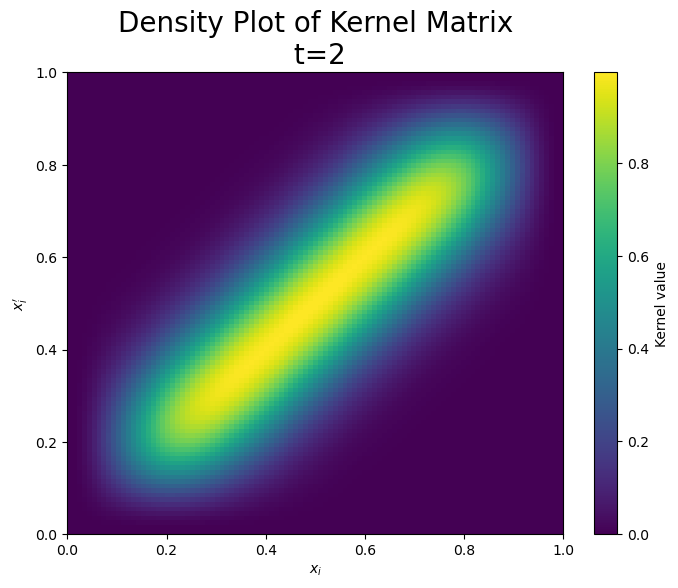

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
rng = np.random.default_rng(1) #

# Parameters
# time = 0
L = 1.0
alpha = 0.01
modes = 5
sigma = 0.01
divisions = 100
x_step = L / divisions
X_array = np.arange(0, L + x_step, x_step)

time_list = [0,0.25,0.5,0.75,1,2]
for time in time_list:
    A = prior_covar(time,modes, alpha, L)
    A_inv_diag = inv_prior_covar(A)

# Calculate the MxM kernel matrix
print("Calculating MxM Kernel Matrix...")
kernel = kernel_matrix(L, modes, X_array, X_array, A_inv_diag)
plt.figure(figsize=(8, 6))
plt.imshow(kernel,extent=(0, L, 0, L), origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label="Kernel value")
plt.title(f"Density Plot of Kernel Matrix\n t={time}",size=20)
plt.xlabel(r"$x_i$")
plt.ylabel(r"$x_i'$")
plt.show()

### Computing the mean prediction:
$$
\begin{align}
\langle T(\mathit{X}, \mathit{X'}) \rangle &= \langle T((x_i, x_i), (x_j', x_j')) \rangle \\
                                           &= \sum_{i,j} K((x,x_j), (x',x_l'))\bar{K}_{i,j}^{-1} T_{j} 
\end{align}
$$
### Here, $T_j$ represents the temperature measurement: $T_j =T(t,(x_j,x_j') ) $ 

In [12]:
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(42)

def measure_T(diffuse: float,
              time: float,
              x_list: list, 
              xp_list: list, 
              Length_x: float,
              coeffs_x: np.ndarray,
              coeffs_y: np.ndarray) -> np.ndarray:
    """
    measures temperatures T(x, y) at specified points,
    where x = x_list[k] and y = xp_list[k] for each index k.
    """
    # Ensure inputs are numpy arrays
    x_pts = np.asarray(x_list)
    y_pts = np.asarray(xp_list) # y coordinates come from xp_list

    Lx = Length_x
    Ly = Length_x 
    c_n = coeffs_x
    c_m = coeffs_y
    N = len(c_n) 

    modes = np.arange(1, N + 1) 
    kx = modes * np.pi / Lx
    ky = modes * np.pi / Ly

    # Calculate the separate exponential decay factors for each mode direction
    exp_decay_n = np.exp(-diffuse * time * kx**2) 
    exp_decay_m = np.exp(-diffuse * time * ky**2) 
    coeffs_combined = np.outer(c_n * exp_decay_n, c_m * exp_decay_m) # Shape (N, N)

    sin_nx_pts = np.sin(np.outer(x_pts, kx))
    sin_my_pts = np.sin(np.outer(y_pts, ky)) 
    temperature_at_points = np.einsum('nm,kn,km->k',
                                       coeffs_combined,
                                       sin_nx_pts,
                                       sin_my_pts,
                                       optimize='optimal')

    return temperature_at_points

def temp_distr_2d(diffuse: float,time: float,
                  Length_x: float, x_array: np.ndarray,
                  coeffs_x: np.ndarray, coeffs_y: np.ndarray) -> np.ndarray:
    ''' 
    Calculates the 2d temperature distribution on a plane
    '''
    Lx = Length_x
    Ly = Length_x
    y_array = x_array
    c_n = coeffs_x
    c_m = coeffs_y

    return sum(
        c_n[n] * c_m[m]
        * np.exp(-diffuse * time * (((n + 1) * np.pi / Lx) ** 2 + ((m + 1) * np.pi / Ly) ** 2))
        * np.sin((n + 1) * np.pi * x_array / Lx)[:, None]
        * np.sin((m + 1) * np.pi * y_array / Ly)[None, :]
        for n in range(len(c_n))
        for m in range(len(c_m))
    )

def prior_covar(time: float,
                N_modes: int, 
                alpha: float,
                Length_x: float) -> np.ndarray:
    """
    Calculates the diagonal prior covariance matrix A explicitly. Assume square domain
        A_{(nm)(nm)} = exp(+alpha * t * [(n*pi/Lx)^2 + (m*pi/Ly)^2])
    Returns a full diagonal matrix of size (Nn*Nm) x (Nn*Nm).
    Uses (n+1) and (m+1) convention for modes matching basis functions.
    """
    t = time
    a = alpha
    modes_n = np.arange(1, N_modes + 1)
    modes_m = np.arange(1, N_modes + 1)

    kx_sq = (modes_n * np.pi / Length_x)**2
    ky_sq = (modes_m * np.pi / Length_x)**2
    k_nm_sq = kx_sq[:, None] + ky_sq[None, :] # Shape (Nn, Nm)

    # Calculate diagonal elements of A (positive exponent)
    A_diag_2d = np.exp(a * t * k_nm_sq) # Note the positive sign here

    # Flatten and create the full diagonal matrix
    A_diag_flat = A_diag_2d.flatten()
    A = np.diag(A_diag_flat)

    return A

def inv_prior_covar(A: np.ndarray) -> np.ndarray:
    """
    Calculates the diagonal elements of the inverse of a diagonal matrix A.
    Efficiently computes 1 / A[i, i].
    """
    # Extract the diagonal elements of A
    diag_A = np.diag(A)
    A_inv_diag = np.divide(1.0, diag_A, out=np.zeros_like(diag_A), where=diag_A!=0)
    # Alternatively:
    # epsilon = 1e-100 # A very small number to prevent division by zero
    # A_inv_diag = 1.0 / (diag_A + epsilon)

    return A_inv_diag

def inv_covar(time: float,
            N_modes: int,
            alpha: float,
            Length_x: float) -> np.ndarray:
    """
    Calculates the diagonal elements of the *inverse* of the prior covariance matrix A (A_inv_diag).
    This corresponds to the prior variance of the coefficients in the GPR kernel construction.

    Assumes A had diagonal elements:
        A_{(nm)(nm)} = exp(+alpha * t * [(n*pi/Lx)^2 + (m*pi/Ly)^2])
    Therefore, the diagonal elements of A_inv are:
        A_inv_{(nm)(nm)} = exp(-alpha * t * [(n*pi/Lx)^2 + (m*pi/Ly)^2])
    """
    t = time
    a = alpha


    Length_y = Length_x

    # Define mode indices (start from 1 as per convention noted)
    modes_n = np.arange(1, N_modes + 1)
    modes_m = np.arange(1, N_modes + 1)

    # Calculate squared wavenumbers
    kx_sq = (modes_n * np.pi / Length_x)**2
    ky_sq = (modes_m * np.pi / Length_y)**2 # Use Length_y here

    # Create a 2D grid of the sum of squared wavenumbers
    # k_nm_sq[n-1, m-1] corresponds to mode (n, m)
    k_nm_sq = kx_sq[:, None] + ky_sq[None, :] # Shape (N_modes, N_modes)

    # Calculate diagonal elements of A_inv directly using NEGATIVE exponent
    # This avoids overflow as the exponent will be negative or zero
    A_inv_diag_2d = np.exp(-a * t * k_nm_sq)

    # Flatten the 2D array of diagonal elements into a 1D array
    A_inv_diag_flat = A_inv_diag_2d.flatten()

    return A_inv_diag_flat

def kernel_function(Lx: float,
                     N_modes: int,
                     x1: float, 
                     x2: float,
                     x1_p: float,
                     x2_p: float,
                     A_inv_diag: np.ndarray)-> float:
    ''' 
    Computes kernel function at time t: 
        K((x1,x1'),(x2,x2')) = \sum_n \sum_m A^{-1}_{(nm),(nm)'} B_n(x_1) B_m(x_2) B_m(x_1') B_m(x_2') 
        B_n(x1) = sin(n pi x1/L) 
    '''
    N = N_modes
    M = N_modes # Assuming N=M often
    modes_n = np.arange(1, N + 1)
    modes_m = np.arange(1, M + 1)
    kx = modes_n * np.pi / Lx
    ky = modes_m * np.pi / Lx

    # Precompute sine terms
    sin_nx1  = np.sin(kx * x1)    # Shape (N,)
    sin_mx2  = np.sin(ky * x2)    # Shape (M,)
    sin_nx1p = np.sin(kx * x1_p)  # Shape (N,)
    sin_mx2p = np.sin(ky * x2_p)  # Shape (M,)

    # Combine spatial basis functions using outer product
    basis_xy  = np.outer(sin_nx1, sin_mx2)    # Shape (N, M)
    basis_xyp = np.outer(sin_nx1p, sin_mx2p)  # Shape (N, M)

    # Reshape A_inv_diag if it's flat
    A_inv_diag_2d = A_inv_diag.reshape((N, M)) # Shape (N, M)

    # Compute kernel by summing element-wise product
    kernel: float = np.sum(A_inv_diag_2d * basis_xy * basis_xyp)

    return kernel

def kernel_matrix(Lx: float,
                     N_modes: int,
                     x1_pts: np.ndarray, 
                     x2_pts: np.ndarray, 
                     A_inv_diag: np.ndarray 
                     ) -> np.ndarray:
    """
    Computes the MxM kernel matrix K[a, b] using vectorization (einsum).\n
    M is the number of measurement points.\n
    Point 'a' is (x1_pts[a], x2_pts[a]).\n
    Point 'b' is (x1_pts[b], x2_pts[b]).\n
    K[a, b] = K((x1_a, x2_a), (x1_b, x2_b))
            = Σ_n Σ_m A⁻¹_{(nm)(nm)} * [sin(k_nx*x1_a)sin(k_my*x2_a)] * [sin(k_nx*x1_b)sin(k_my*x2_b)]
    """
    N,M = N_modes, N_modes # Assuming square grid of modes (Nn=Nm=N)
    modes_n, modes_m = np.arange(1, N + 1), np.arange(1, M + 1)
    kx,ky = modes_n * np.pi / Lx, modes_m * np.pi / Lx
    A_inv_diag_2d = A_inv_diag.reshape((N, M)) # Index 'nm'

    # Calculate sine terms evaluated at all points for all modes
    sin_nx_pts = np.sin(np.outer(x1_pts, kx)) 
    sin_my_pts = np.sin(np.outer(x2_pts, ky)) 

    # Compute the kernel matrix K[a, b] using einsum
    kernel_mat = np.einsum('nm,an,am,bn,bm->ab',
                           A_inv_diag_2d,
                           sin_nx_pts, sin_my_pts,
                           sin_nx_pts, sin_my_pts, # Use same arrays for point b
                           optimize='optimal')
    return kernel_mat

def data_covar(Lx: float,
                  N_modes_n: int, 
                  x1_measured: np.ndarray, 
                  x2_measured: np.ndarray, 
                  A_inv_diag: np.ndarray,
                  sigma: float,
                  kernel_func_2d: callable) -> np.ndarray:
    """
    Builds the M x M covariance matrix Kbar for the 2D measurement points.
    Kbar[a, b] = K((x1_a, x2_a), (x1_b, x2_b)) + sigma^2 * delta_ab
    """
    M = len(x1_measured)
    Kbar_base = np.zeros((M, M))
    for a in range(M):
        for b in range(M):
            Kbar_base[a, b] = kernel_func_2d(Lx, N_modes_n,
                                            x1_measured[a], x2_measured[a], # Point a (x, y)
                                            x1_measured[b], x2_measured[b], # Point b (x', y')
                                            A_inv_diag)

    Kbar: np.ndarray = Kbar_base + (sigma**2) * np.eye(M)
    return Kbar

def mean_prediction(x1_pred: float,
                       x2_pred: float,
                       Lx: float, 
                       N_modes: int,
                       A_inv_diag: np.ndarray,
                       kernel_func_2d: callable,
                       Kbar_MM_inv: np.ndarray, # MxM Inverse Covariance Matrix
                       x1_measured: np.ndarray, x2_measured: np.ndarray,
                       T_measured: np.ndarray) -> float:
    """
    Calculates the GPR mean prediction at a 2D point (x1_pred, x2_pred).
    """
    M = len(x1_measured)

    # 1. Calculate the vector K_pred (correlations between pred point and measured points)
    K_pred_vec = np.zeros(M)
    for a in range(M):
        K_pred_vec[a] = kernel_func_2d(Lx, N_modes,
                                       x1_pred, x2_pred,             # Prediction point (x, y)
                                       x1_measured[a], x2_measured[a], # Measurement point a (x', y')
                                       A_inv_diag)

    # 2. Calculate Kbar_MM_inv @ T_measured
    weights = Kbar_MM_inv @ T_measured
    mean_pred = K_pred_vec @ weights

    return mean_pred

def mean_prediction_matrix(x_pred_grid: np.ndarray, # 1D array of x prediction coords
                            y_pred_grid: np.ndarray, # 1D array of y prediction coords
                            Lx: float,
                            N_modes_n: int,
                            A_inv_diag: np.ndarray,
                            Kbar_MM_inv: np.ndarray, # MxM Inverse Covariance Matrix
                            x1_measured: np.ndarray, # x-coordinates of M points
                            x2_measured: np.ndarray, # y-coordinates of M points
                            T_measured: np.ndarray) -> np.ndarray:
    """
    Calculates the GPR mean prediction for all points on a grid efficiently.
    """
    N = N_modes_n
    M = N_modes_n # Assuming N=M

    modes_n = np.arange(1, N + 1)
    modes_m = np.arange(1, M + 1)
    kx = modes_n * np.pi / Lx
    ky = modes_m * np.pi / Lx

    # Reshape A_inv_diag to (N, M_modes)
    A_inv_diag_2d = A_inv_diag.reshape((N, M)) # Index 'nm'

    # Precompute weights (constant for all predictions)
    weights = Kbar_MM_inv @ T_measured # Shape (M_meas,)

    # Precompute sine terms for ALL prediction points
    sin_nx_pred = np.sin(np.outer(x_pred_grid, kx))
    sin_my_pred = np.sin(np.outer(y_pred_grid, ky)) 

    # Precompute sine terms for ALL measurement points
    sin_nx_meas = np.sin(np.outer(x1_measured, kx)) 
    sin_my_meas = np.sin(np.outer(x2_measured, ky))

    # Compute the N_pred x M_meas kernel prediction matrix using einsum
    K_pred_all = np.einsum('nm,pn,pm,an,am->pa',
                           A_inv_diag_2d,
                           sin_nx_pred, sin_my_pred,
                           sin_nx_meas, sin_my_meas,
                           optimize='optimal') # Shape (N_pred, M_meas)

    # Calculate all mean predictions with a single matrix-vector product
    mean_pred_flat = K_pred_all @ weights # Shape (N_pred,)

    return mean_pred_flat



## Solution

[ 0.02364325  0.90092739 -0.71168077  0.89729889 -0.3763371  -0.1533471
  0.65540519 -0.18160173  0.09918738 -0.94488177]
[0.51182162 0.9504637  0.14415961 0.94864945 0.31183145 0.42332645
 0.82770259 0.40919914 0.54959369 0.02755911 0.75351311 0.53814331
 0.32973172 0.7884287  0.30319483]
Prediction complete.
Plotting...


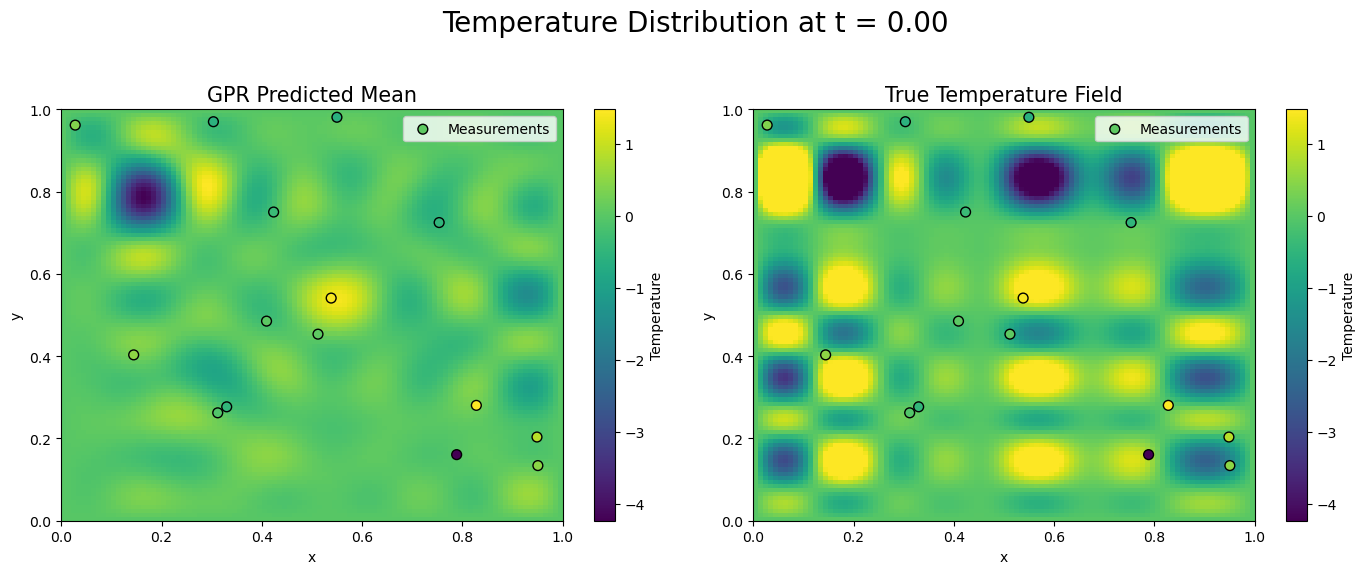

Prediction complete.
Plotting...


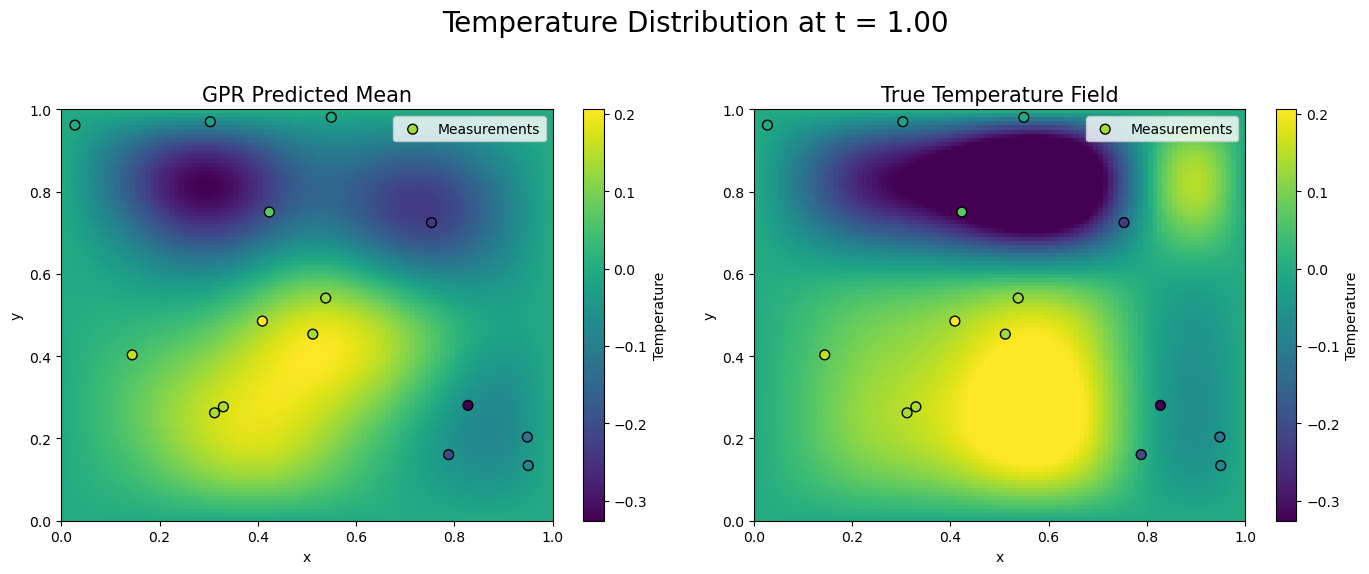

Prediction complete.
Plotting...


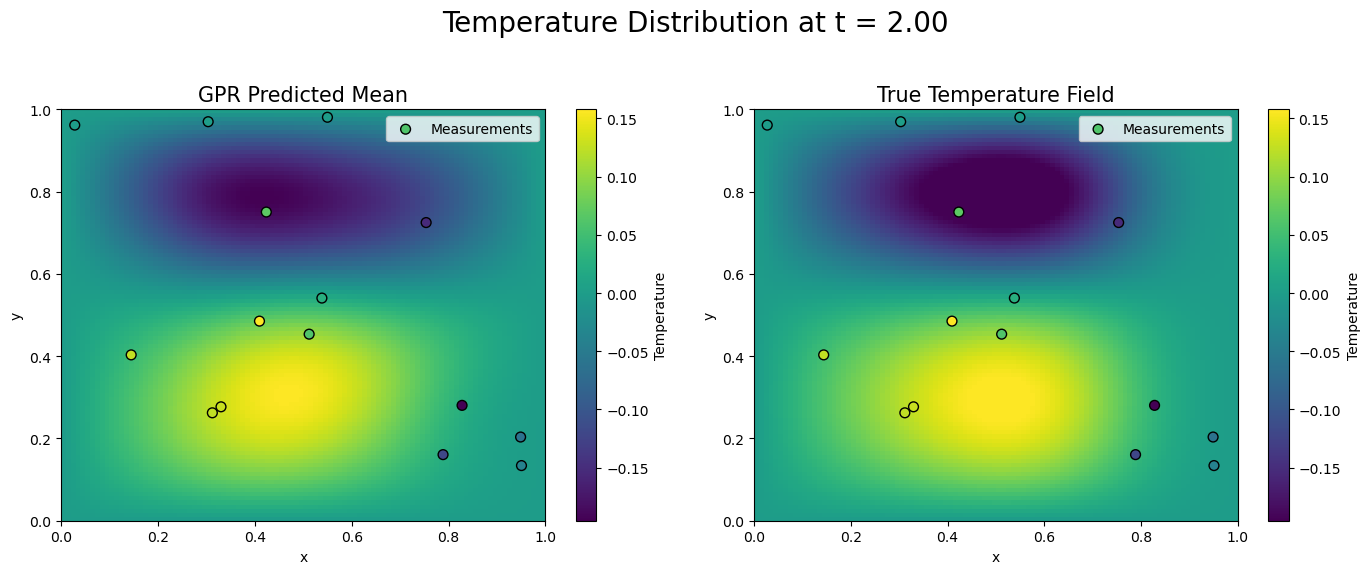

Prediction complete.
Plotting...


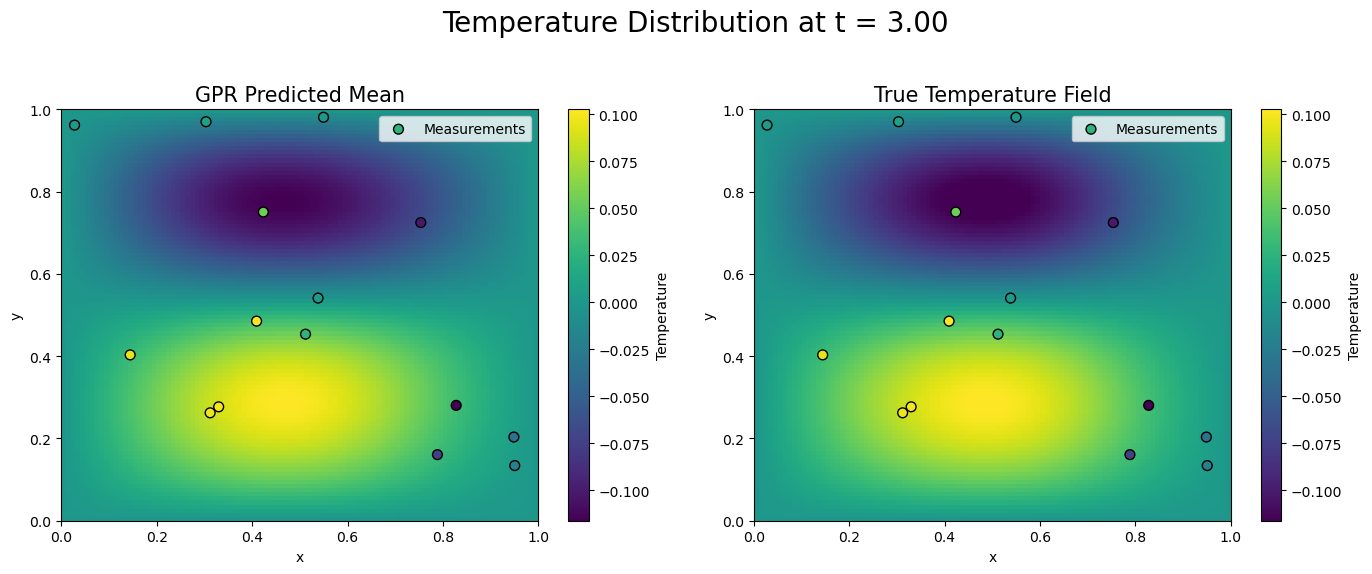

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
rng = np.random.default_rng(1) 

# --- Parameters ---
L = 1.0           # Assume square domain Lx = Ly = L
alpha = 0.01
modes = 10       # Use same number of modes in each direction for simplicity Nn = Nm = N
sigma = 0.01      # Measurement noise
grid_res = 100 # Resolution for plotting
num_measurements = 15

# Generate random Fourier coefficients
c_n,c_m = rng.uniform(-1, 1, modes), rng.uniform(-1, 1, modes)
print(c_n)
# Define Measurement Points (e.g., 5 points)
rng_measurements = np.random.default_rng(1)
x1_measure = rng_measurements.uniform(0, L, size=num_measurements)
x2_measure = rng_measurements.uniform(0, L, size=num_measurements)
print(x1_measure)
# Define Prediction Grid
x_plot,y_plot = np.linspace(0, L, grid_res), np.linspace(0, L, grid_res)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

# Flatten prediction grid coordinates
x_pred_flat = X_plot.flatten()
y_pred_flat = Y_plot.flatten()


# --- Time Loop for Plotting/Animation ---
time_list = [0, 1.0, 2.0,3.0] # Example times

for time in time_list:
    measured_temps = measure_T(alpha, time, x1_measure, x2_measure, L, c_n, c_m)
    A_inv_diag = inv_covar(time, modes, alpha, L)
    Kbar = data_covar(L, modes, x1_measure, x2_measure, A_inv_diag, sigma, kernel_function)
    Kbar_inv = linalg.inv(Kbar) 

    T_pred_flat = mean_prediction_matrix(
        x_pred_flat, y_pred_flat,
        L,  modes, A_inv_diag,
        Kbar_inv,
        x1_measure, x2_measure,
        measured_temps
    )

    # Reshape the flat prediction array back to the grid shape
    T_pred_grid = T_pred_flat.reshape((grid_res, grid_res))
    print("Prediction complete.")

    T_true_grid = temp_distr_2d(alpha, time, L, x_plot, c_n, c_m)
    # --- Plotting ---
    print("Plotting...")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Temperature Distribution at t = {time:.2f}",size=20)

    # Predicted Mean
    im0 = axes[0].imshow(T_pred_grid.T, extent=(0, L, 0, L), origin='lower', cmap='viridis', aspect='auto')
    axes[0].scatter(x1_measure, x2_measure, c=measured_temps, cmap='viridis', edgecolor='k', s=50, label='Measurements')
    axes[0].set_title("GPR Predicted Mean",size=15)
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    fig.colorbar(im0, ax=axes[0], label="Temperature")
    axes[0].legend()

    # True Field
    im1 = axes[1].imshow(T_true_grid, extent=(0, L, 0, L), origin='lower', cmap='viridis', aspect='auto', vmin=im0.get_clim()[0], vmax=im0.get_clim()[1]) # Use same color scale
    axes[1].scatter(x1_measure, x2_measure, c=measured_temps, cmap='viridis', edgecolor='k', s=50, label='Measurements')
    axes[1].set_title("True Temperature Field",size=15)
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    fig.colorbar(im1, ax=axes[1], label="Temperature")
    axes[1].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Animation:

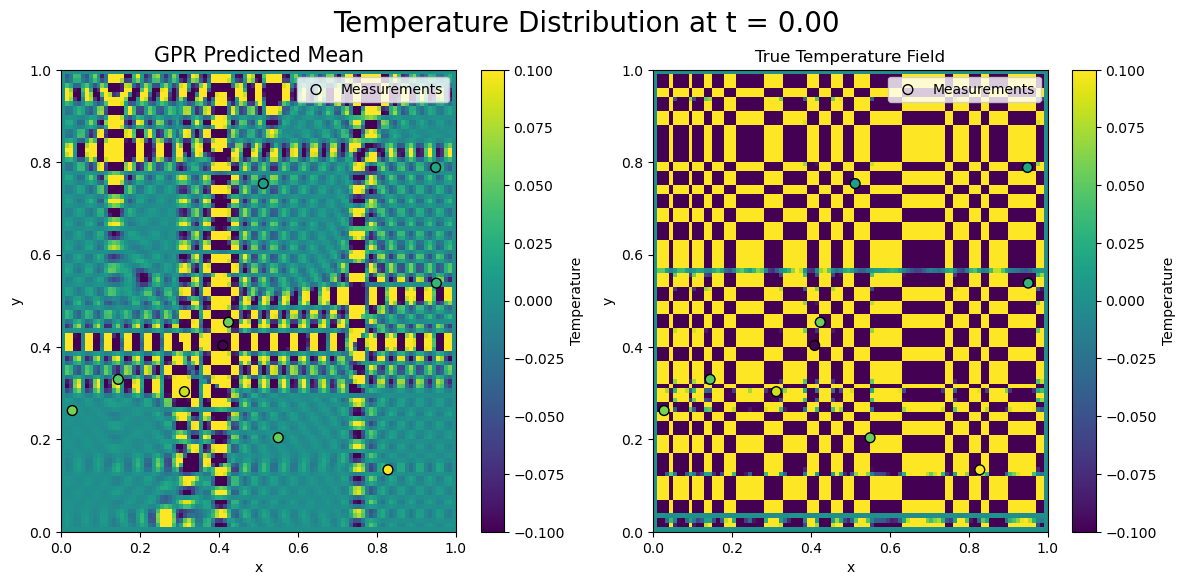

Animation saved as surface_temp_profile.mp4


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation,  FFMpegWriter
from scipy import linalg
rng = np.random.default_rng(1)

# --- Parameters ---
L = 1.0           # Assume square domain Lx = Ly = L
alpha = 0.01
modes = 40       # Use same number of modes in each direction for simplicity Nn = Nm = N
sigma = 0.01      # Measurement noise
grid_res = 100  # Resolution for plottig
num_measurements = 10

# Generate random Fourier coefficients
c_n, c_m = rng.uniform(-1, 1, modes), rng.uniform(-1, 1, modes)

# Define Measurement Points
rng_measurements = np.random.default_rng(1)
x1_measure = rng_measurements.uniform(0, L, size=num_measurements)
x2_measure = rng_measurements.uniform(0, L, size=num_measurements)

# Define Prediction Grid
x_plot, y_plot = np.linspace(0, L, grid_res), np.linspace(0, L, grid_res)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)

# Flatten prediction grid coordinates
x_pred_flat = X_plot.flatten()
y_pred_flat = Y_plot.flatten()

# --- Animation Function ---
def animate_temperature(time_list):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].set_title("GPR Predicted Mean", size=15)
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    im_pred = axes[0].imshow(np.zeros((grid_res, grid_res)).T, extent=(0, L, 0, L),
                             origin='lower', cmap='viridis', aspect='auto')
    scatter_pred = axes[0].scatter([], [], c=[], cmap='viridis', edgecolor='k', s=50, label="Measurements")
    fig.colorbar(im_pred, ax=axes[0], label="Temperature")
    axes[0].legend(loc="upper right")  # Add legend for scatter plot

    axes[1].set_title("True Temperature Field")
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")
    im_true = axes[1].imshow(np.zeros((grid_res, grid_res)), extent=(0, L, 0, L),
                              origin='lower', cmap='viridis', aspect='auto')
    scatter_true = axes[1].scatter([], [], c=[], cmap='viridis', edgecolor='k', s=50, label="Measurements")
    fig.colorbar(im_true, ax=axes[1], label="Temperature")
    axes[1].legend(loc="upper right")  # Add legend for scatter plot

    def update(frame):
        time = time_list[frame]
        measured_temps = measure_T(alpha, time, x1_measure, x2_measure, L, c_n, c_m)
        A_inv_diag = inv_covar(time, modes, alpha, L)
        Kbar = data_covar(L, modes, x1_measure, x2_measure, A_inv_diag, sigma, kernel_function)
        Kbar_inv = linalg.inv(Kbar)

        T_pred_flat = mean_prediction_matrix(
            x_pred_flat, y_pred_flat,
            L, modes, A_inv_diag,
            Kbar_inv,
            x1_measure, x2_measure,
            measured_temps
        )
        T_pred_grid = T_pred_flat.reshape((grid_res, grid_res))
        T_true_grid = temp_distr_2d(alpha, time, L, x_plot, c_n, c_m)

        # Update predicted temperature plot
        im_pred.set_array(T_pred_grid.T)
        scatter_pred.set_offsets(np.c_[x1_measure, x2_measure])
        scatter_pred.set_array(measured_temps)

        # Update true temperature plot
        im_true.set_array(T_true_grid)
        scatter_true.set_offsets(np.c_[x1_measure, x2_measure])
        scatter_true.set_array(measured_temps)

        fig.suptitle(f"Temperature Distribution at t = {time:.2f}", size=20)
        return im_pred, scatter_pred, im_true, scatter_true

    ani = FuncAnimation(fig, update, frames=len(time_list), interval=1000, blit=True)
    plt.show()
    # Save the animation
    writer = FFMpegWriter(fps=15, metadata=dict(artist='GPT'), bitrate=1800)
    ani.save("surface_temp_profile.mp4", writer=writer)
    print("Animation saved as surface_temp_profile.mp4")

# --- Run Animation ---
t_divisions = 100; t_max = 3.0
t_array = np.linspace(0, t_max, t_divisions + 1)
animate_temperature(t_array)


# 2D temperature distribution

Max absolute T at t=0: 7.7362e+00
Max absolute T at t=1: 6.0667e-01
Max absolute T at t=2: 2.4252e-01
Max absolute T at t=3: 1.2252e-01
Max absolute T at t=4: 6.7222e-02
Max absolute T at t=5: 4.0879e-02


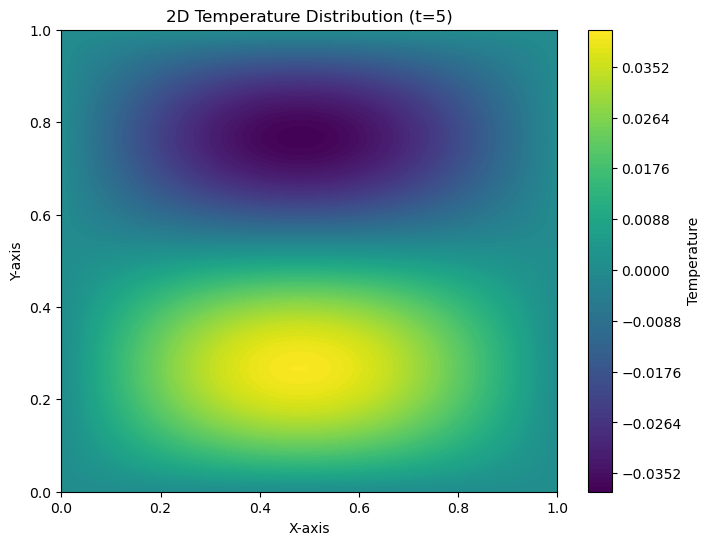

In [4]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(1)

def temp_distr_2d(diffuse: float,time: float,
                  Length_x: float, x_array: np.ndarray,
                  coeffs_x: np.ndarray, coeffs_y: np.ndarray) -> np.ndarray:
    ''' 
    Calculates the 2d temperature distribution on a plane
    '''
    Lx = Length_x
    Ly = Length_x
    y_array = x_array
    c_n = coeffs_x
    c_m = coeffs_y

    return sum(
        c_n[n] * c_m[m]
        * np.exp(-diffuse * time * (((n + 1) * np.pi / Lx) ** 2 + ((m + 1) * np.pi / Ly) ** 2))
        * np.sin((n + 1) * np.pi * x_array / Lx)[:, None]
        * np.sin((m + 1) * np.pi * y_array / Ly)[None, :]
        for n in range(len(c_n))
        for m in range(len(c_m))
    )


# Constants
L = 1.0  # Length of the square plane
modes = 10   # Number of Fourier modes in each direction
grid_res = 50   # Resolution of the grid
alpha = 0.01  # Diffusivity constant
time_list = [0,1,2,3,4,5]

# for time in time_list: 
# Generate grid
x_array, y_array = np.linspace(0, L, grid_res), np.linspace(0, L, grid_res)

c_n,c_m = rng.uniform(-1, 1, modes), rng.uniform(-1, 1, modes)

for time in time_list: 
    Temp_distr = temp_distr_2d(alpha, time, L, x_array, c_n, c_m)
    max_abs_90 = np.max(np.abs(Temp_distr))
    print(f"Max absolute T at t={time}: {max_abs_90:.4e}")

# --- Plotting T(t=90) as a Density Plot ---
X, Y = np.meshgrid(x_array, y_array)
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Temp_distr, cmap='viridis', levels=100)
plt.colorbar(label="Temperature")
plt.title(f"2D Temperature Distribution (t={time})")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()
